In [1]:
!pip install -q /kaggle/input/tabpfn-019-whl/tabpfn-0.1.9-py3-none-any.whl

In [2]:
!mkdir /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/tabpfn-019-whl/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pytz import timezone
from datetime import datetime, timedelta, date
import json
import itertools
from tqdm import tqdm
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import KFold, train_test_split, RepeatedStratifiedKFold, LeaveOneOut, StratifiedKFold
from tabpfn import TabPFNClassifier

import sys
sys.path.append('../input/iterativestratification')
from iterstrat.ml_stratifiers import RepeatedMultilabelStratifiedKFold

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
df_train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
df_test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
df_sub = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
df_greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")

In [5]:
def balance_logloss(y_true, y_pred):
    y_pred = np.stack([1-y_pred, y_pred]).T
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    #y_pred / np.sum(y_pred, axis=1)[:, None]
    nc = np.bincount(y_true)
    logloss = (-1/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(y_pred[:,0]))) - 1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred[:,1])))) / 2

    return logloss

metric = balance_logloss

In [6]:
random_state = 13
learning_rate = 0.1

base_params_dict = {
    "LightGBM" : {
        "objective": "binary",
        "metric": "binary_logloss",
        "random_state": random_state,
        "verbose": -1,
        "learning_rate": learning_rate,
        },
    "XGBoost" : {
        "objective": "binary:logistic",
        "random_state": random_state,
        "learning_rate": learning_rate,
        'eval_metric': 'logloss',
        "tree_method": "gpu_hist",
    },
}

# LightGBM + HardPointCV

In [7]:
target = "Class"
n_splits = 10
n_repeats = 10
num_boost_round = 1000
stopping_rounds = 50
learning_rate = 0.1
n_trials = 300
model_name = "LightGBM"

# FE
df_train["EJ"] = df_train["EJ"].replace({'A':0, 'B':1})
df_test["EJ"] = df_test["EJ"].replace({'A':0, 'B':1})

# HardPoint
hp = [509, 313, 479, 267, 408, 193, 145, 229, 31, 434]
hps = [1 if i in hp else 0 for i in range(len(df_train))]
df_train["HardPoint"] = hps

# EX
ex_columns = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'] # All

exclude_columns = []

ex_columns = sorted(list(set(ex_columns) - set(exclude_columns)))
use_columns = ex_columns + [target]
X_sub = df_test[ex_columns]

display(df_train.head())

print(ex_columns)
print(len(ex_columns))

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,HardPoint
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0


['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
56


In [8]:
best_params = {'objective': 'binary', 'metric': 'binary_logloss', 'random_state': 13, 'verbose': -1, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 353, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.07285502530384627, 'max_bin': 63, 'subsample': 0.5572107119770833, 'subsample_freq': 0, 'feature_fraction': 0.49006914678241065, 'reg_alpha': 1.1978900147063292e-05, 'reg_lambda': 7.80448230256196e-06, 'scale_pos_weight': 27.352771232270825}
params = {**base_params_dict[model_name], **best_params}
print(params)

{'objective': 'binary', 'metric': 'binary_logloss', 'random_state': 13, 'verbose': -1, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 353, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.07285502530384627, 'max_bin': 63, 'subsample': 0.5572107119770833, 'subsample_freq': 0, 'feature_fraction': 0.49006914678241065, 'reg_alpha': 1.1978900147063292e-05, 'reg_lambda': 7.80448230256196e-06, 'scale_pos_weight': 27.352771232270825}


In [9]:
np.random.seed(random_state)

labels = df_train[["HardPoint", "Class"]]
cv = RepeatedMultilabelStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state+111)

evals_results = []
model1_preds = df_sub[["Id"]].copy()
scores = []

y = df_train[target]
X = df_train[ex_columns]
model1_oof = np.zeros(len(y))

for i, (train_index, val_index) in enumerate(cv.split(X, labels)):
    print("=" * 20, f"START FOLD {i+1}", "=" * 20)
    y_train = y.iloc[train_index].to_numpy()
    X_train = X.iloc[train_index].to_numpy()
    y_val = y.iloc[val_index].to_numpy()
    X_val = X.iloc[val_index].to_numpy()

    #########
    # LightGBM
    #########
    if model_name=="LightGBM":
        data_train = lgb.Dataset(X_train, y_train)
        data_val = lgb.Dataset(X_val, y_val)
        evals_result = {}

        model = lgb.train(
            params,
            train_set=data_train,
            valid_sets=[data_train, data_val],
            num_boost_round=num_boost_round,
            callbacks=[
                lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=True),
                lgb.record_evaluation(evals_result),
            ],
        )
        # 検証データ
        y_pred = model.predict(X_val)
        score = metric(y_val, y_pred)
        scores.append(score)
        model1_oof[val_index] += y_pred / n_repeats
        # 提出用データ
        pred = model.predict(X_sub)
        model1_preds[f"pred_{i+1}"] = pred

==================== START FOLD 1 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.00267841	valid_1's binary_logloss: 0.109056
==================== START FOLD 2 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00234184	valid_1's binary_logloss: 0.110322
==================== START FOLD 3 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.00391154	valid_1's binary_logloss: 0.120555
==================== START FOLD 4 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.00959849	valid_1's binary_logloss: 0.231031
==================== START FOLD 5 ====================
Training until validation

/tmp/ipykernel_23/324956156.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  model1_preds[f"pred_{i+1}"] = pred


In [10]:
print(f"Score mean: {np.mean(scores)}")
print(f"oof Score mean: {metric(y, model1_oof)}")

Score mean: 0.19966716657458528
oof Score mean: 0.1716920724856611


In [11]:
model1_preds["class_1"] = model1_preds.drop("Id", axis=1).mean(axis=1).tolist()
model1_preds["class_0"] = (1 - model1_preds["class_1"]).tolist()
model1_preds.head()

/tmp/ipykernel_23/2725093147.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  model1_preds["class_1"] = model1_preds.drop("Id", axis=1).mean(axis=1).tolist()
/tmp/ipykernel_23/2725093147.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  model1_preds["class_0"] = (1 - model1_preds["class_1"]).tolist()


,Id,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19,pred_20,pred_21,pred_22,pred_23,pred_24,pred_25,pred_26,pred_27,pred_28,pred_29,pred_30,pred_31,pred_32,pred_33,pred_34,pred_35,pred_36,pred_37,pred_38,pred_39,pred_40,pred_41,pred_42,pred_43,pred_44,pred_45,pred_46,pred_47,pred_48,pred_49,...,pred_53,pred_54,pred_55,pred_56,pred_57,pred_58,pred_59,pred_60,pred_61,pred_62,pred_63,pred_64,pred_65,pred_66,pred_67,pred_68,pred_69,pred_70,pred_71,pred_72,pred_73,pred_74,pred_75,pred_76,pred_77,pred_78,pred_79,pred_80,pred_81,pred_82,pred_83,pred_84,pred_85,pred_86,pred_87,pred_88,pred_89,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99,pred_100,class_1,class_0
0,00eed32682bb,0.012038,0.025992,0.135041,0.08754,0.190641,0.021145,0.050264,0.030484,0.07442,0.014735,0.140669,0.11606,0.200298,0.179447,0.09055,0.074146,0.057277,0.158453,0.07023,0.287781,0.043823,0.097248,0.014342,0.07335,0.122987,0.12438,0.0706,0.014131,0.080452,0.058202,0.379883,0.051994,0.034434,0.080427,0.08906,0.067441,0.02648,0.066437,0.059719,0.055147,0.020675,0.130681,0.05192,0.047997,0.087659,0.233071,0.044034,0.195231,0.087471,...,0.215512,0.15667,0.148774,0.001568,0.143561,0.056464,0.038422,0.01864,0.026862,0.168265,0.003964,0.01067,0.295883,0.084071,0.171458,0.071303,0.014065,0.02131,0.077145,0.027658,0.019318,0.150282,0.032593,0.022746,0.104199,0.182705,0.241377,0.148547,0.051326,0.07352,0.096315,0.074368,0.122008,0.14354,0.086266,0.077234,0.049306,0.182765,0.208849,0.224775,0.022863,0.174186,0.052935,0.044002,0.034277,0.103193,0.126305,0.080259,0.09344,0.90656
1,010ebe33f668,0.012038,0.025992,0.135041,0.08754,0.190641,0.021145,0.050264,0.030484,0.07442,0.014735,0.140669,0.11606,0.200298,0.179447,0.09055,0.074146,0.057277,0.158453,0.07023,0.287781,0.043823,0.097248,0.014342,0.07335,0.122987,0.12438,0.0706,0.014131,0.080452,0.058202,0.379883,0.051994,0.034434,0.080427,0.08906,0.067441,0.02648,0.066437,0.059719,0.055147,0.020675,0.130681,0.05192,0.047997,0.087659,0.233071,0.044034,0.195231,0.087471,...,0.215512,0.15667,0.148774,0.001568,0.143561,0.056464,0.038422,0.01864,0.026862,0.168265,0.003964,0.01067,0.295883,0.084071,0.171458,0.071303,0.014065,0.02131,0.077145,0.027658,0.019318,0.150282,0.032593,0.022746,0.104199,0.182705,0.241377,0.148547,0.051326,0.07352,0.096315,0.074368,0.122008,0.14354,0.086266,0.077234,0.049306,0.182765,0.208849,0.224775,0.022863,0.174186,0.052935,0.044002,0.034277,0.103193,0.126305,0.080259,0.09344,0.90656
2,02fa521e1838,0.012038,0.025992,0.135041,0.08754,0.190641,0.021145,0.050264,0.030484,0.07442,0.014735,0.140669,0.11606,0.200298,0.179447,0.09055,0.074146,0.057277,0.158453,0.07023,0.287781,0.043823,0.097248,0.014342,0.07335,0.122987,0.12438,0.0706,0.014131,0.080452,0.058202,0.379883,0.051994,0.034434,0.080427,0.08906,0.067441,0.02648,0.066437,0.059719,0.055147,0.020675,0.130681,0.05192,0.047997,0.087659,0.233071,0.044034,0.195231,0.087471,...,0.215512,0.15667,0.148774,0.001568,0.143561,0.056464,0.038422,0.01864,0.026862,0.168265,0.003964,0.01067,0.295883,0.084071,0.171458,0.071303,0.014065,0.02131,0.077145,0.027658,0.019318,0.150282,0.032593,0.022746,0.104199,0.182705,0.241377,0.148547,0.051326,0.07352,0.096315,0.074368,0.122008,0.14354,0.086266,0.077234,0.049306,0.182765,0.208849,0.224775,0.022863,0.174186,0.052935,0.044002,0.034277,0.103193,0.126305,0.080259,0.09344,0.90656
3,040e15f562a2,0.012038,0.025992,0.135041,0.08754,0.190641,0.021145,0.050264,0.030484,0.07442,0.014735,0.140669,0.11606,0.200298,0.179447,0.09055,0.074146,0.057277,0.158453,0.07023,0.287781,0.043823,0.097248,0.014342,0.07335,0.122987,0.12438,0.0706,0.014131,0.080452,0.058202,0.379883,0.051994,0.034434,0.080427,0.08906,0.067441,0.02648,0.066437,0.059719,0.055147,0.020675,0.130681,0.05192,0.047997,0.087659,0.233071,0.044034,0.195231,0.087471,...,0.215512,0.15667,0.148774,0.001568,0.143561,0.056464,0.038422,0.01864,0.026862,0.168265,0.

# XGBoost + NestedCV

In [12]:
target = "Class"
random_state = 13
n_splits = 10
num_boost_round = 1000
stopping_rounds = 50
learning_rate = 0.1
n_trials = 300
model_name = "XGBoost"

df_train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
df_test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
df_sub = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
df_greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")


# FE
df_train["EJ"] = df_train["EJ"].replace({'A':0, 'B':1})
df_test["EJ"] = df_test["EJ"].replace({'A':0, 'B':1})

# EX
ex_columns = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'] # All

exclude_columns = []

ex_columns = sorted(list(set(ex_columns) - set(exclude_columns)))
use_columns = ex_columns + [target]
X_sub = df_test[ex_columns]

display(df_train.head())

print(ex_columns)
print(len(ex_columns))

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
56


In [13]:
best_cv_params = [{'min_child_weight': 8,
  'max_depth': 17,
  'max_delta_step': 7.428803969367076,
  'subsample': 0.7920569357442612,
  'colsample_bytree': 0.9731010296239732,
  'gamma': 0.011371581333620819,
  'scale_pos_weight': 155.09900324714164},
 {'min_child_weight': 6,
  'max_depth': 12,
  'max_delta_step': 18.09220194779129,
  'subsample': 0.7010637164370721,
  'colsample_bytree': 0.6202802949673988,
  'gamma': 2.4276207158251635e-06,
  'scale_pos_weight': 77.05477788071082},
 {'min_child_weight': 7,
  'max_depth': 44,
  'max_delta_step': 8.607817932565986,
  'subsample': 0.8318320589603841,
  'colsample_bytree': 0.4355186701914686,
  'gamma': 1.2487845561482165e-05,
  'scale_pos_weight': 201.21791081062247},
 {'min_child_weight': 9,
  'max_depth': 6,
  'max_delta_step': 8.555054870917278,
  'subsample': 0.7113482335377683,
  'colsample_bytree': 0.6121685564892682,
  'gamma': 2.319644405596966e-05,
  'scale_pos_weight': 102.41277731980534},
 {'min_child_weight': 7,
  'max_depth': 21,
  'max_delta_step': 7.783986712189754,
  'subsample': 0.6538816038301629,
  'colsample_bytree': 0.7153539636716781,
  'gamma': 7.734810091814072e-06,
  'scale_pos_weight': 71.05476915193654},
 {'min_child_weight': 7,
  'max_depth': 44,
  'max_delta_step': 11.576507464953075,
  'subsample': 0.6615916949825313,
  'colsample_bytree': 0.3391423869190513,
  'gamma': 0.0004551091955707892,
  'scale_pos_weight': 160.8558351721162},
 {'min_child_weight': 8,
  'max_depth': 29,
  'max_delta_step': 7.538637784459595,
  'subsample': 0.9107151436938841,
  'colsample_bytree': 0.8897571647738725,
  'gamma': 2.0506808841691723e-09,
  'scale_pos_weight': 84.37760083879326},
 {'min_child_weight': 7,
  'max_depth': 35,
  'max_delta_step': 12.653663000448985,
  'subsample': 0.7472661201571688,
  'colsample_bytree': 0.4013032545066121,
  'gamma': 0.25500762211520384,
  'scale_pos_weight': 172.97973668960879},
 {'min_child_weight': 7,
  'max_depth': 47,
  'max_delta_step': 10.32403314731059,
  'subsample': 0.6548989327197157,
  'colsample_bytree': 0.9084438440111091,
  'gamma': 6.347715018571132e-07,
  'scale_pos_weight': 42.15400063527052},
 {'min_child_weight': 5,
  'max_depth': 36,
  'max_delta_step': 2.665744246392611,
  'subsample': 0.9501494253117905,
  'colsample_bytree': 0.516559545007966,
  'gamma': 5.623009240626623e-07,
  'scale_pos_weight': 296.4576172851205}]

In [14]:
outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
X, y = df_train[ex_columns], df_train[target]
model2_preds = df_sub[["Id"]].copy()
scores = []
model2_oof = np.zeros(len(y))
np.random.seed(random_state)

# 外側のCV
for i, (train_inds, test_inds) in enumerate(outer_cv.split(X, y)):
    print(f"***** Out CV {i} *****")
    X_train_out, y_train_out = X.iloc[train_inds], y.iloc[train_inds]
    X_test, y_test = X.iloc[test_inds], y.iloc[test_inds]

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    param = {**base_params_dict[model_name], **best_cv_params[i]}

    # 最後にX_testで評価
    data_train = xgb.DMatrix(X_train_out, y_train_out)
    data_test = xgb.DMatrix(X_test, y_test)
    data_sub = xgb.DMatrix(X_sub)
    evals_result = {}
    model = xgb.train(
        param,
        dtrain=data_train,
        num_boost_round=num_boost_round,
        evals=[(data_train, "train"), (data_test, "val")],
        early_stopping_rounds=stopping_rounds,
        verbose_eval=False,
        evals_result=evals_result
    )
    y_pred = model.predict(data_test)
    score = metric(y_test, y_pred)
    scores.append(score)
    model2_oof[test_inds] = y_pred
    # 提出用データ
    pred = model.predict(data_sub)
    model2_preds[f"pred_{i+1}"] = pred

***** Out CV 0 *****
***** Out CV 1 *****
***** Out CV 2 *****
***** Out CV 3 *****
***** Out CV 4 *****
***** Out CV 5 *****
***** Out CV 6 *****
***** Out CV 7 *****
***** Out CV 8 *****
***** Out CV 9 *****


In [15]:
print(f"Score mean: {np.mean(scores)}, Score var: {np.var(scores)}")

Score mean: 0.1859770658729706, Score var: 0.02545220655889065


In [16]:
model2_preds["class_1"] = model2_preds.drop("Id", axis=1).mean(axis=1).tolist()
model2_preds["class_0"] = (1 - model2_preds["class_1"]).tolist()
model2_preds.head()

,Id,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,class_1,class_0
0,00eed32682bb,0.233156,0.467711,0.134117,0.429134,0.186543,0.285808,0.349782,0.191995,0.310409,0.232898,0.282155,0.717845
1,010ebe33f668,0.233156,0.467711,0.134117,0.429134,0.186543,0.285808,0.349782,0.191995,0.310409,0.232898,0.282155,0.717845
2,02fa521e1838,0.233156,0.467711,0.134117,0.429134,0.186543,0.285808,0.349782,0.191995,0.310409,0.232898,0.282155,0.717845
3,040e15f562a2,0.233156,0.467711,0.134117,0.429134,0.186543,0.285808,0.349782,0.191995,0.310409,0.232898,0.282155,0.717845
4,046e85c7cc7f,0.233156,0.467711,0.134117,0.429134,0.186543,0.285808,0.349782,0.191995,0.310409,0.232898,0.282155,0.717845


# TabPFN

In [17]:
random_state = 13
n_splits = 10
n_repeats = 10

df_train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
df_test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
df_sub = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
df_greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")

# FE
df_train["EJ"] = df_train["EJ"].replace({'A':0, 'B':1})
df_test["EJ"] = df_test["EJ"].replace({'A':0, 'B':1})

ex_columns = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
exclude_columns = []
ex_columns = sorted(list(set(ex_columns) - set(exclude_columns)))
use_columns = ex_columns + [target]
X_sub = df_test[ex_columns]

display(df_train.head())

print(ex_columns)
print(len(ex_columns))

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
56


In [18]:
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state+111)
df_preds = df_sub[["Id"]].copy()
scores = []

y = df_train[target]
X = df_train[ex_columns]

model3_preds = df_sub[["Id"]].copy()
model3_oof = np.zeros(len(y))

for i, (train_index, val_index) in enumerate(cv.split(X, y)):
    print("=" * 20, f"START FOLD {i+1}", "=" * 20)
    y_train = y.iloc[train_index].to_numpy()
    X_train = X.iloc[train_index].to_numpy()
    y_val = y.iloc[val_index].to_numpy()
    X_val = X.iloc[val_index].to_numpy()

    model = TabPFNClassifier(N_ensemble_configurations=64, device='cuda:0')
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    score = metric(y_val, y_pred)
    scores.append(score)
    model3_oof[val_index] += y_pred / n_repeats
    
    # 提出用データ
    pred = model.predict_proba(X_sub)[:, 1]
    model3_preds[f"pred_{i+1}"] = pred

==================== START FOLD 1 ====================
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
==================== START FOLD 2 ====================
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
==================== START FOLD 3 ====================
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
==================== START FOLD 4 ====================
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
==================== START FOLD 5 ====================
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
==================== START FOLD 6 ====================
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
==================== START FOLD 7 ====================
Loading model that can be used for inference only
U

/tmp/ipykernel_23/4129957716.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  model3_preds[f"pred_{i+1}"] = pred


In [19]:
print(f"Score mean: {np.mean(scores)}")
print(f"oof Score mean: {metric(df_train[target], model3_oof)}")

Score mean: 0.3771251063073964
oof Score mean: 0.3690115966232314


In [20]:
model3_preds["class_1"] = model3_preds.drop("Id", axis=1).mean(axis=1).tolist()
model3_preds["class_0"] = (1 - model3_preds["class_1"]).tolist()
model3_preds.head()

/tmp/ipykernel_23/1708353678.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  model3_preds["class_1"] = model3_preds.drop("Id", axis=1).mean(axis=1).tolist()
/tmp/ipykernel_23/1708353678.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  model3_preds["class_0"] = (1 - model3_preds["class_1"]).tolist()


,Id,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19,pred_20,pred_21,pred_22,pred_23,pred_24,pred_25,pred_26,pred_27,pred_28,pred_29,pred_30,pred_31,pred_32,pred_33,pred_34,pred_35,pred_36,pred_37,pred_38,pred_39,pred_40,pred_41,pred_42,pred_43,pred_44,pred_45,pred_46,pred_47,pred_48,pred_49,...,pred_53,pred_54,pred_55,pred_56,pred_57,pred_58,pred_59,pred_60,pred_61,pred_62,pred_63,pred_64,pred_65,pred_66,pred_67,pred_68,pred_69,pred_70,pred_71,pred_72,pred_73,pred_74,pred_75,pred_76,pred_77,pred_78,pred_79,pred_80,pred_81,pred_82,pred_83,pred_84,pred_85,pred_86,pred_87,pred_88,pred_89,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99,pred_100,class_1,class_0
0,00eed32682bb,0.486626,0.266114,0.329985,0.381091,0.318438,0.343325,0.332939,0.315942,0.35793,0.339916,0.374096,0.336846,0.369171,0.327333,0.368727,0.327148,0.315132,0.329116,0.352492,0.395083,0.273321,0.392576,0.329311,0.352917,0.451257,0.403674,0.327206,0.336845,0.31011,0.319097,0.329701,0.35433,0.399262,0.292417,0.371391,0.43788,0.268418,0.348067,0.300686,0.359076,0.328841,0.389331,0.477851,0.340024,0.320667,0.313341,0.348723,0.295654,0.334055,...,0.360403,0.361425,0.311121,0.330622,0.288767,0.295824,0.356378,0.347843,0.295498,0.363151,0.288831,0.323705,0.36124,0.384168,0.337279,0.325347,0.411305,0.395288,0.294686,0.466519,0.367848,0.27515,0.3349,0.35515,0.304164,0.332547,0.318042,0.390003,0.257252,0.347721,0.32725,0.314639,0.371706,0.415569,0.408612,0.360701,0.361048,0.30191,0.329552,0.443688,0.323746,0.267841,0.275786,0.294942,0.372752,0.434201,0.376813,0.3762,0.347443,0.652557
1,010ebe33f668,0.486626,0.266114,0.329985,0.381091,0.318438,0.343325,0.332939,0.315942,0.35793,0.339916,0.374096,0.336846,0.369171,0.327333,0.368727,0.327148,0.315132,0.329116,0.352492,0.395083,0.273321,0.392576,0.329311,0.352917,0.451257,0.403674,0.327206,0.336845,0.31011,0.319097,0.329701,0.35433,0.399262,0.292417,0.371391,0.43788,0.268418,0.348067,0.300686,0.359076,0.328841,0.389331,0.477851,0.340024,0.320667,0.313341,0.348723,0.295654,0.334055,...,0.360403,0.361425,0.311121,0.330622,0.288767,0.295824,0.356378,0.347843,0.295498,0.363151,0.288831,0.323705,0.36124,0.384168,0.337279,0.325347,0.411305,0.395288,0.294686,0.466519,0.367848,0.27515,0.3349,0.35515,0.304164,0.332547,0.318042,0.390003,0.257252,0.347721,0.32725,0.314639,0.371706,0.415569,0.408612,0.360701,0.361048,0.30191,0.329552,0.443688,0.323746,0.267841,0.275786,0.294942,0.372752,0.434201,0.376813,0.3762,0.347443,0.652557
2,02fa521e1838,0.486626,0.266114,0.329985,0.381091,0.318438,0.343325,0.332939,0.315942,0.35793,0.339916,0.374096,0.336846,0.369171,0.327333,0.368727,0.327148,0.315132,0.329116,0.352492,0.395083,0.273321,0.392576,0.329311,0.352917,0.451257,0.403674,0.327206,0.336845,0.31011,0.319097,0.329701,0.35433,0.399262,0.292417,0.371391,0.43788,0.268418,0.348067,0.300686,0.359076,0.328841,0.389331,0.477851,0.340024,0.320667,0.313341,0.348723,0.295654,0.334055,...,0.360403,0.361425,0.311121,0.330622,0.288767,0.295824,0.356378,0.347843,0.295498,0.363151,0.288831,0.323705,0.36124,0.384168,0.337279,0.325347,0.411305,0.395288,0.294686,0.466519,0.367848,0.27515,0.3349,0.35515,0.304164,0.332547,0.318042,0.390003,0.257252,0.347721,0.32725,0.314639,0.371706,0.415569,0.408612,0.360701,0.361048,0.30191,0.329552,0.443688,0.323746,0.267841,0.275786,0.294942,0.372752,0.434201,0.376813,0.3762,0.347443,0.652557
3,040e15f562a2,0.486626,0.266114,0.329985,0.381091,0.318438,0.343325,0.332939,0.315942,0.35793,0.339916,0.374096,0.336846,0.369171,0.327333,0.368727,0.327148,0.315132,0.329116,0.352492,0.395083,0.273321,0.392576,0.329311,0.352917,0.451257,0.403674,0.327206,0.336845,0.31011,0.319097,0.329701,0.35433,0.399262,0.292417,0.371391,0.43788,0.268418,0.348067,0.300686,0.359076,0.328841,0.389331,0.477851,0.340024,0.320667,0.313341,0.348723,0.295654,0.334055,...,0.360403,0.361425,0.311121,0.330622,0.288767,0.295824,0.35637

# LightGBM + NestedCV

In [21]:
target = "Class"
random_state = 13
n_splits = 10
num_boost_round = 1000
stopping_rounds = 50
learning_rate = 0.1
n_trials = 300
model_name = "LightGBM"

df_train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
df_test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
df_sub = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
df_greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")


# FE
df_train["EJ"] = df_train["EJ"].replace({'A':0, 'B':1})
df_test["EJ"] = df_test["EJ"].replace({'A':0, 'B':1})

# EX
ex_columns = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'] # All

exclude_columns = []

ex_columns = sorted(list(set(ex_columns) - set(exclude_columns)))
use_columns = ex_columns + [target]
X_sub = df_test[ex_columns]

display(df_train.head())

print(ex_columns)
print(len(ex_columns))

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
56


In [22]:
best_cv_params = [{'max_depth': 3, 'num_leaves': 51, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.08637809153718612, 'max_bin': 133, 'subsample': 0.5064145001524588, 'subsample_freq': 3, 'feature_fraction': 0.16235118405130844, 'reg_alpha': 0.10995532541271508, 'reg_lambda': 0.0005646201562204504, 'scale_pos_weight': 24.41388167411479}, {'max_depth': 4, 'num_leaves': 41, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.025525456894214503, 'max_bin': 177, 'subsample': 0.558518599899886, 'subsample_freq': 4, 'feature_fraction': 0.6719922974261585, 'reg_alpha': 0.0015480871808771868, 'reg_lambda': 0.39672268268496197, 'scale_pos_weight': 46.69234130241483}, {'max_depth': 3, 'num_leaves': 338, 'min_data_in_leaf': 21, 'min_gain_to_split': 3.7454257412486616, 'max_bin': 502, 'subsample': 0.4948537941906335, 'subsample_freq': 1, 'feature_fraction': 0.8623678720169038, 'reg_alpha': 2.1869241946636042e-06, 'reg_lambda': 9.004663294554265e-07, 'scale_pos_weight': 20.997515955144113}, {'max_depth': 5, 'num_leaves': 253, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.7255942067581924, 'max_bin': 119, 'subsample': 0.6503703259820698, 'subsample_freq': 1, 'feature_fraction': 0.6043586645285949, 'reg_alpha': 0.009844181876172238, 'reg_lambda': 0.009499769539641614, 'scale_pos_weight': 68.85918507416122}, {'max_depth': 8, 'num_leaves': 55, 'min_data_in_leaf': 6, 'min_gain_to_split': 4.333232358237045, 'max_bin': 286, 'subsample': 0.7179702184884593, 'subsample_freq': 1, 'feature_fraction': 0.4333028945426099, 'reg_alpha': 0.028802959049079372, 'reg_lambda': 0.0002760087123277094, 'scale_pos_weight': 28.880688189391368}, {'max_depth': 3, 'num_leaves': 60, 'min_data_in_leaf': 24, 'min_gain_to_split': 3.3932475721381037, 'max_bin': 268, 'subsample': 0.5016487829591301, 'subsample_freq': 1, 'feature_fraction': 0.694134726389784, 'reg_alpha': 1.2343444127530416e-07, 'reg_lambda': 3.036253125121441e-08, 'scale_pos_weight': 37.88927825506205}, {'max_depth': 5, 'num_leaves': 10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.9436273173334714, 'max_bin': 467, 'subsample': 0.7923792392254261, 'subsample_freq': 4, 'feature_fraction': 0.7653371964487882, 'reg_alpha': 0.06672342182361392, 'reg_lambda': 9.184235220202404e-07, 'scale_pos_weight': 35.048496128895856}, {'max_depth': 6, 'num_leaves': 448, 'min_data_in_leaf': 8, 'min_gain_to_split': 1.080178638356669, 'max_bin': 293, 'subsample': 0.6635508385595192, 'subsample_freq': 1, 'feature_fraction': 0.43932137326681225, 'reg_alpha': 0.00192565651735273, 'reg_lambda': 3.444554709746977, 'scale_pos_weight': 48.929896223989246}, {'max_depth': 3, 'num_leaves': 350, 'min_data_in_leaf': 80, 'min_gain_to_split': 10.088046158122664, 'max_bin': 298, 'subsample': 0.7287525511357824, 'subsample_freq': 3, 'feature_fraction': 0.23839761568586276, 'reg_alpha': 0.01379146464309962, 'reg_lambda': 1.1047850106749175, 'scale_pos_weight': 5.548911994874806}, {'max_depth': 4, 'num_leaves': 277, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.008462452382852037, 'max_bin': 114, 'subsample': 0.9692844748757705, 'subsample_freq': 0, 'feature_fraction': 0.5947877824759527, 'reg_alpha': 1.4001566018102642, 'reg_lambda': 0.0024869599944277727, 'scale_pos_weight': 27.219213112922905}]

In [23]:
outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
X, y = df_train[ex_columns], df_train[target]
model4_preds = df_sub[["Id"]].copy()
scores = []
model4_oof = np.zeros(len(y))
np.random.seed(random_state)

# 外側のCV
for i, (train_inds, test_inds) in enumerate(outer_cv.split(X, y)):
    print(f"***** Out CV {i} *****")
    X_train_out, y_train_out = X.iloc[train_inds], y.iloc[train_inds]
    X_test, y_test = X.iloc[test_inds], y.iloc[test_inds]

    params = {**base_params_dict[model_name], **best_cv_params[i]}

    # 最後にX_testで評価
    data_train = lgb.Dataset(X_train_out, y_train_out)
    data_val = lgb.Dataset(X_test, y_test)
    evals_result = {}
    model = lgb.train(
        params,
        train_set=data_train,
        valid_sets=[data_train, data_val],
        num_boost_round=num_boost_round,
        callbacks=[
            lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=True),
            lgb.record_evaluation(evals_result),
        ],
    )
    y_pred = model.predict(X_test)
    score = metric(y_test, y_pred)
    scores.append(score)
    model4_oof[test_inds] = y_pred
    # 提出用データ
    pred = model.predict(X_sub)
    model4_preds[f"pred_{i+1}"] = pred

***** Out CV 0 *****
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0706397	valid_1's binary_logloss: 0.288624
***** Out CV 1 *****
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.0222547	valid_1's binary_logloss: 0.162845
***** Out CV 2 *****
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0523293	valid_1's binary_logloss: 0.115127
***** Out CV 3 *****
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0231675	valid_1's binary_logloss: 0.118251
***** Out CV 4 *****
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.124023	valid_1's binary_logloss: 0.298886
***** Out CV 5 *****
Traini

In [24]:
print(f"Score mean: {np.mean(scores)}, Score var: {np.var(scores)}")

Score mean: 0.21240880935310505, Score var: 0.02278429938280975


In [25]:
model4_preds["class_1"] = model4_preds.drop("Id", axis=1).mean(axis=1).tolist()
model4_preds["class_0"] = (1 - model4_preds["class_1"]).tolist()
model4_preds.head()

,Id,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,class_1,class_0
0,00eed32682bb,0.558004,0.046667,0.407371,0.15053,0.022696,0.235702,0.410301,0.087282,0.524441,0.332833,0.277583,0.722417
1,010ebe33f668,0.558004,0.046667,0.407371,0.15053,0.022696,0.235702,0.410301,0.087282,0.524441,0.332833,0.277583,0.722417
2,02fa521e1838,0.558004,0.046667,0.407371,0.15053,0.022696,0.235702,0.410301,0.087282,0.524441,0.332833,0.277583,0.722417
3,040e15f562a2,0.558004,0.046667,0.407371,0.15053,0.022696,0.235702,0.410301,0.087282,0.524441,0.332833,0.277583,0.722417
4,046e85c7cc7f,0.558004,0.046667,0.407371,0.15053,0.022696,0.235702,0.410301,0.087282,0.524441,0.332833,0.277583,0.722417


# WoE + LR

https://www.kaggle.com/code/tatudoug/logistic-regression-baseline/notebook

In [26]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import pandas as pd
from numpy import dot, exp
import random
from sklearn.model_selection import KFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
import copy 
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')


greeks['k'] = greeks['Alpha']+greeks['Beta']+greeks['Gamma']+greeks['Delta']
train = pd.merge( greeks[['k','Id']],train,on='Id')

names = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
target_name = 'Class'

train['EJ'] = pd.Series(np.where(train.EJ.values == 'A', 1, 0),
          train.index)
test['EJ'] = pd.Series(np.where(test.EJ.values == 'A', 1, 0),
          test.index)

# fill nan data with mean values 
train[names] = train[names].fillna(train[names].mean())
test[names] = test[names].fillna(train[names].mean())
# clip values to avoid different values in the test set from train
test = test[names].clip(train[names].min(axis=0).values,train[names].max(axis=0).values, axis=1)

# data scaled to allow the features interaction (by multiplication)
scaler = StandardScaler()

train2 = copy.copy(train)
teste2 = copy.copy(test)

vals = scaler.fit_transform(train[names])
vals_test = scaler.transform(test[names])

train2[names] = vals
teste2[names] = vals_test



# def multiply and make a array of all interactions
def mab(df,nome1,nome2):
    a  = df[nome1]*df[nome2]
    return(a/max(a))
h = []
ht = []
n = 1
for n1 in names:
    for n2 in names[n:]:
        h.append(mab(train2,n1,n2).rename(n1+'_mul_'+n2))
        ht.append(mab(teste2,n1,n2).rename(n1+'_mul_'+n2)) 
    n+=1
    
newF = pd.DataFrame(h)
newF_test = pd.DataFrame(ht)


#https://lucastiagooliveira.github.io/datascience/iv/woe/python/2020/12/15/iv_woe.html
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        
        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

# mult特徴量は入れてない元のカラムだけでiv_woeを計算している
a,b = iv_woe(train2, target_name, bins=10, show_woe=False)


# Reordering the dataframe to keep IV with higger values in front
trainE = train[a.sort_values(by='IV',ascending=False).Variable.values]
trainE[target_name] = train[target_name]
testeE = test[a.sort_values(by='IV',ascending=False).Variable.values[2:]]

# join the original vars and the interactions between them
# 掛け算特徴量をconcatしておく
ff = pd.concat([trainE,newF.T],axis=1)
ff_teste = pd.concat([testeE,newF_test.T],axis=1)

# multも対象にしてもう一回計算している
a,b = iv_woe(ff, target_name, bins=10, show_woe=False)

# deleting all IVs below 0.05
a = a.loc[a['IV']> 0.05]

allNames = a.sort_values(by='IV',ascending=False).Variable.values
crossNames = [x for x in allNames if '_mul_' in x]

nomes2 = list(trainE)+crossNames
nomes2.remove('Class')


# threshold to correlation features
threshold = 0.3

cc = ff[nomes2[2:]].corr()

mat_x = abs(cc)>threshold
mat_x = mat_x.to_numpy()


# selection tof the variables with low correlation, there are +- 70 features with low correlation
var1 = []
nomes = list(cc)
var1.append(nomes[0]) # IV高いカラムで絞った時の最初のカラムと各カラムの相関
max_vars = 100

count = 1
for n in range(1,len(nomes)):
    
    if (mat_x[n,:n+1].sum() ) == 1:
        
        var1.append(nomes[n])        
        count+=1
        
        if(count == max_vars):
            break

            
# create dic with WoE transformation
list_dics = []

for var in var1:
    df_temp = b.loc[b['Variable']==var].reset_index()
    # criando dicionario
    dict_var = {}
    for x in range(len(df_temp)):
        line = df_temp.iloc[x]
        dict_var[ line['Cutoff'] ] = line['WoE']
    list_dics.append(dict_var)
    

# train and test data
df_original = ff[var1+[target_name]+ ['k'] ]
df_teste2 = ff_teste[var1]
names = var1

# In this part there is some data leakage as the map is using the full dataset
n= 0

for var in var1:
    df_original.loc[:,var] = df_original[var].map(list_dics[n])
    df_teste2.loc[:,var] = df_teste2[var].map(list_dics[n])

    n=n+1
    
df_original.loc[:,names] = df_original[names].fillna(df_original[names].mean())
df_teste2.loc[:,names] = df_teste2[names].fillna(df_original[names].mean())

In [27]:
def lr_nested_cv(X, y, params):
    
    nested_scores, best_cv_params = [], []
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    # 外側のCV
    for i, (train_inds, test_inds) in enumerate(outer_cv.split(X, y)):
        print(f"***** Out CV {i} *****")
        X_train_out, y_train_out = X.iloc[train_inds], y.iloc[train_inds]
        X_test, y_test = X.iloc[test_inds], y.iloc[test_inds]

        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        best_params, best_score = None, 1000000
        for C in params:
            scores = []
            for j, (train_idx, val_idx) in enumerate(cv.split(X_train_out, y_train_out)):
                X_train_in, y_train_in = X_train_out.iloc[train_idx], y_train_out.iloc[train_idx]
                X_val, y_val = X_train_out.iloc[val_idx], y_train_out.iloc[val_idx]

                model = LogisticRegression(C=C, random_state=random_state, l1_ratio=l1_ratio,
                                     solver=solver, class_weight=class_weight, penalty=penalty, max_iter=max_iter)
                model.fit(X_train_in, y_train_in)
                y_pred = model.predict_proba(X_val)[:, 1]
                score = metric(y_val, y_pred)
                scores.append(score)

            # このoutFoldで一番よかったCを決める
            cv_score = np.mean(scores)
            if best_score > cv_score:
                best_params = C
                best_score = cv_score

        print(f"params：{best_params}, score：{best_score}")
        model = LogisticRegression(C=best_params, random_state=random_state, l1_ratio=l1_ratio,
                                 solver=solver, class_weight=class_weight, penalty=penalty, max_iter=max_iter)
        model.fit(X_train_out, y_train_out)
        y_pred = model.predict_proba(X_test)[:, 1]
        score = metric(y_test, y_pred)
        nested_scores.append(score)
        best_cv_params.append(best_params)
    return nested_scores, best_cv_params

n_splits = 10
solver="liblinear"
class_weight="balanced"
penalty="l2"
l1_ratio = None
max_iter = 1000
random_state = 13
params = [0.001, 0.01, 0.1, 1.0, 10, 100]
X, y = df_original[names], df_original[target_name]
nested_scores, best_cv_params = lr_nested_cv(X, y, params)
print(np.mean(nested_scores))


#X_sub = df_test[ex_columns]
X_sub = df_teste2[names]
model5_preds = df_sub[["Id"]].copy()
scores = []
model5_oof = np.zeros(len(y))

outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
# 外側のCV
for i, (train_inds, test_inds) in enumerate(outer_cv.split(X, y)):
    print(f"***** Out CV {i} *****")
    X_train_out, y_train_out = X.iloc[train_inds], y.iloc[train_inds]
    X_test, y_test = X.iloc[test_inds], y.iloc[test_inds]

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    C = best_cv_params[i]
    model = LogisticRegression(C=C, random_state=random_state, l1_ratio=l1_ratio,
                                solver=solver, class_weight=class_weight, penalty=penalty, max_iter=max_iter)
    model.fit(X_train_out, y_train_out)
    y_pred = model.predict_proba(X_test)[:, 1]
    score = metric(y_test, y_pred)
    scores.append(score)
    model5_oof[test_inds] = y_pred
    
    # 提出用データ
    pred = model.predict_proba(X_sub)[:, 1]
    model5_preds[f"pred_{i+1}"] = pred

print(np.mean(scores))

***** Out CV 0 *****
params：0.1, score：0.17698052743939482
***** Out CV 1 *****
params：0.1, score：0.20324375113826867
***** Out CV 2 *****
params：0.1, score：0.20454661506125354
***** Out CV 3 *****
params：0.1, score：0.18794923474486833
***** Out CV 4 *****
params：0.1, score：0.19153289231652312
***** Out CV 5 *****
params：0.1, score：0.19281163835946102
***** Out CV 6 *****
params：0.1, score：0.1995234659196253
***** Out CV 7 *****
params：0.1, score：0.2052976700556822
***** Out CV 8 *****
params：0.1, score：0.16393992261410026
***** Out CV 9 *****
params：0.1, score：0.197744397734064
0.1896884967633897
***** Out CV 0 *****
***** Out CV 1 *****
***** Out CV 2 *****
***** Out CV 3 *****
***** Out CV 4 *****
***** Out CV 5 *****
***** Out CV 6 *****
***** Out CV 7 *****
***** Out CV 8 *****
***** Out CV 9 *****
0.1896884967633897


In [28]:
display(df_original.head(2))
display(df_teste2.head(2))

,DU,GL,CR,DA,AF,EE,FR,DE,CC,BN,FI,FE,DH,EU,GH,DY,CB,FC,BR,FS,AZ,CW,EG,DU_mul_FE,DA_mul_DU,CR_mul_DE,DI_mul_FE,BQ_mul_FE,BQ_mul_CB,BQ_mul_CW,DA_mul_DL,CR_mul_GE,EE_mul_GF,CR_mul_FE,BQ_mul_FC,DE_mul_GE,CD _mul_DF,CR_mul_GI,DE_mul_DL,DL_mul_EL,BN_mul_BQ,BN_mul_DA,CU_mul_DN,AZ_mul_GL,CW _mul_DL,DE_mul_EL,CW _mul_EE,BN_mul_CR,DE_mul_GF,DH_mul_EG,CC_mul_EL,CU_mul_EG,DN_mul_FI,AZ_mul_FE,DN_mul_EL,CW _mul_EL,AZ_mul_CU,CW _mul_DY,DH_mul_DL,AX_mul_CU,DY_mul_FI,BN_mul_DE,BN_mul_CW,BN_mul_DY,AZ_mul_EL,AZ_mul_DE,Class,k
0,2.367078,0.223446,1.679529,-0.222751,0.223446,-0.683275,0.576868,-0.359226,0.143403,0.352614,0.952480,0.016386,0.036189,-0.677305,-0.340534,0.143403,-0.340534,-0.359226,0.223446,-0.117390,-0.098342,0.036189,0.223446,0.832477,1.679529,1.679529,0.244065,0.516243,0.881267,0.599340,0.429726,1.356161,-0.203702,0.318173,0.576868,-0.511106,0.494264,0.576868,0.016386,-0.098342,-0.359226,-0.078924,-0.665257,-0.078924,0.733556,0.143403,0.016386,0.59934,0.016386,0.143403,0.016386,0.036189,0.408219,-1.106440,-0.078924,-0.078924,-0.492757,-0.359226,0.016386,0.244065,0.733556,-0.883297,0.429726,-0.222751,0.408219,-0.203702,1,BCGD
1,-0.408497,-0.506550,-0.683275,-0.222751,-0.511106,0.881267,-0.173725,-0.203702,0.733556,-0.995214,-0.665257,-0.683275,0.056392,0.599340,-0.359226,0.576868,0.016386,-0.359226,0.318173,-0.359226,-0.098342,-0.492757,-0.203702,-1.123832,-0.222751,-0.511106,-0.883297,-0.511106,-0.511106,-0.511106,-0.511106,-0.359226,-1.123832,-0.222751,-0.359226,0.223446,0.494264,-0.222751,0.656499,0.318173,0.223446,-0.098342,-0.665257,-1.123832,-0.865597,0.494264,0.408219,0.59934,-0.683275,0.143403,0.494264,0.036189,-0.222751,-0.078924,0.952480,-0.078924,0.318173,-0.098342,-0.511106,-0.665257,-0.222751,-0.340534,-0.829229,-0.340534,-0.222751,-0.683275,0,ACMB


,DU,GL,CR,DA,AF,EE,FR,DE,CC,BN,FI,FE,DH,EU,GH,DY,CB,FC,BR,FS,AZ,CW,EG,DU_mul_FE,DA_mul_DU,CR_mul_DE,DI_mul_FE,BQ_mul_FE,BQ_mul_CB,BQ_mul_CW,DA_mul_DL,CR_mul_GE,EE_mul_GF,CR_mul_FE,BQ_mul_FC,DE_mul_GE,CD _mul_DF,CR_mul_GI,DE_mul_DL,DL_mul_EL,BN_mul_BQ,BN_mul_DA,CU_mul_DN,AZ_mul_GL,CW _mul_DL,DE_mul_EL,CW _mul_EE,BN_mul_CR,DE_mul_GF,DH_mul_EG,CC_mul_EL,CU_mul_EG,DN_mul_FI,AZ_mul_FE,DN_mul_EL,CW _mul_EL,AZ_mul_CU,CW _mul_DY,DH_mul_DL,AX_mul_CU,DY_mul_FI,BN_mul_DE,BN_mul_CW,BN_mul_DY,AZ_mul_EL,AZ_mul_DE
0,-0.408497,1.809828,1.679529,1.809828,-0.511106,0.881267,-0.173725,1.290806,1.022249,-0.735461,0.95248,-0.511106,1.208567,-0.677305,0.297554,-1.123832,0.576868,-0.359226,0.318173,0.068712,-0.03989,0.228561,-0.098342,0.881267,1.679529,1.679529,1.158275,0.656499,-0.359226,0.1232,1.158275,1.356161,1.022249,0.494264,-0.359226,1.290806,0.494264,0.656499,1.158275,-0.883297,0.733556,0.318173,0.408219,0.808379,0.733556,-0.222751,0.95248,0.016386,0.881267,0.881267,0.408219,0.408219,0.95248,0.1232,0.95248,-0.098342,0.576868,-0.222751,0.656499,-0.222751,-0.511106,0.1232,-0.628216,-0.222751,0.016386,0.656499
1,-0.408497,1.809828,1.679529,1.809828,-0.511106,0.881267,-0.173725,1.290806,1.022249,-0.735461,0.95248,-0.511106,1.208567,-0.677305,0.297554,-1.123832,0.576868,-0.359226,0.318173,0.068712,-0.03989,0.228561,-0.098342,0.881267,1.679529,1.679529,1.158275,0.656499,-0.359226,0.1232,1.158275,1.356161,1.022249,0.494264,-0.359226,1.290806,0.494264,0.656499,1.158275,-0.883297,0.733556,0.318173,0.408219,0.808379,0.733556,-0.222751,0.95248,0.016386,0.881267,0.881267,0.408219,0.408219,0.95248,0.1232,0.95248,-0.098342,0.576868,-0.222751,0.656499,-0.222751,-0.511106,0.1232,-0.628216,-0.222751,0.016386,0.656499


In [29]:
model5_preds["class_1"] = model5_preds.drop("Id", axis=1).mean(axis=1).tolist()
model5_preds["class_0"] = (1 - model5_preds["class_1"]).tolist()
model5_preds.head()

,Id,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,class_1,class_0
0,00eed32682bb,0.998912,0.99811,0.997878,0.998852,0.999001,0.998022,0.998333,0.998251,0.998584,0.998253,0.99842,0.00158
1,010ebe33f668,0.998912,0.99811,0.997878,0.998852,0.999001,0.998022,0.998333,0.998251,0.998584,0.998253,0.99842,0.00158
2,02fa521e1838,0.998912,0.99811,0.997878,0.998852,0.999001,0.998022,0.998333,0.998251,0.998584,0.998253,0.99842,0.00158
3,040e15f562a2,0.998912,0.99811,0.997878,0.998852,0.999001,0.998022,0.998333,0.998251,0.998584,0.998253,0.99842,0.00158
4,046e85c7cc7f,0.998912,0.99811,0.997878,0.998852,0.999001,0.998022,0.998333,0.998251,0.998584,0.998253,0.99842,0.00158


# Ensemble

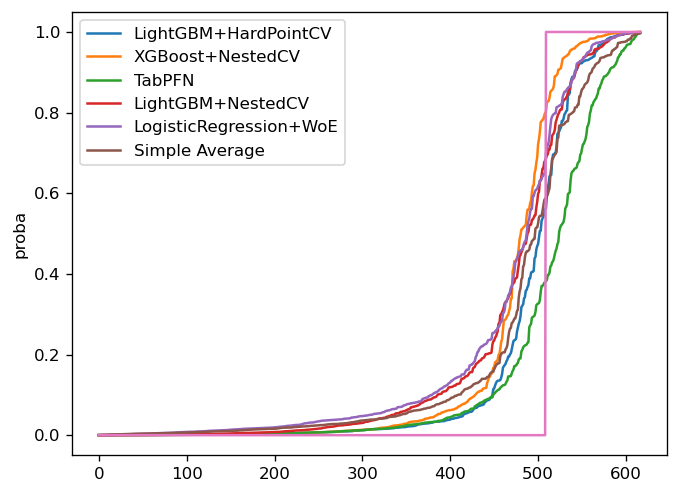

0.18120809674083782


In [30]:
fig, ax = plt.subplots(dpi=120)
sns.lineplot(np.sort(model1_oof), ax=ax, label="LightGBM+HardPointCV")
sns.lineplot(np.sort(model2_oof), ax=ax, label="XGBoost+NestedCV")
sns.lineplot(np.sort(model3_oof), ax=ax, label="TabPFN")
sns.lineplot(np.sort(model4_oof), ax=ax, label="LightGBM+NestedCV")
sns.lineplot(np.sort(model5_oof), ax=ax, label="LogisticRegression+WoE")
sns.lineplot(np.sort((model1_oof+model2_oof+model3_oof+model4_oof+model5_oof)/5), ax=ax, label="Simple Average")
sns.lineplot([0]*509 + [1]*108, ax=ax)
ax.set_ylabel("proba")
plt.show()

print(metric(df_train["Class"].to_numpy(), (model1_oof+model2_oof+model3_oof+model4_oof+model5_oof)/5))

### 加重平均ベース

In [31]:
# result = []
# ws = list(range(1, 11))
# thresh_holds = [i/10 for i in range(1, 10)]

# for w in ws:
#     for th in thresh_holds:
#         r = []
#         for l, x in zip(model1_oof, model2_oof):
#             ms = np.mean(x+l)
#             if ms<th:
#                 r.append(((w-1)*l + x)/w)
#             else:
#                 r.append(((w-1)*x + l)/w)        
#         s = metric(df_train["Class"].to_numpy(), np.array(r))
#         result.append([w, th, s])

# result = pd.DataFrame(result, columns=["weight", "thresh_hold", "SCORE"]).sort_values("SCORE")

# bw = result.iloc[0]["weight"]
# bth = result.iloc[0]["thresh_hold"]
# df_oof = np.zeros(len(df_train))
# for i, (l, x) in enumerate(zip(model1_oof, model2_oof)):
#     ms = np.mean(x+l)
#     if ms<bth: # 閾値以下なら0ぽいので、0の予測に強い意見を尊重する
#         df_oof[i] = ((bw-1)*l + x)/bw
#     else: # 閾値以上なら1ぽいので、1の予測に強い意見を尊重する
#         df_oof[i] = ((bw-1)*x + l)/bw      
# df_oof = pd.DataFrame(df_oof, columns=["proba"])
# df_oof["Class"] = df_train["Class"].tolist()

# fig, ax = plt.subplots(dpi=120)
# sns.lineplot(np.sort(model1_oof), ax=ax, label="LightGBM+HardPointCV")
# sns.lineplot(np.sort(model2_oof), ax=ax, label="XGBoost+NestedCV")
# sns.lineplot(np.sort(df_oof["proba"].to_numpy()), ax=ax, label="ensemble")
# sns.lineplot([0]*509 + [1]*108, ax=ax)
# ax.set_ylabel("proba")
# plt.show()

# print(bw, bth)
# print(metric(df_oof["Class"].to_numpy(), df_oof["proba"].to_numpy()))

In [32]:
# submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
# df_result = np.zeros(len(submission))

# for i, (l, x) in enumerate(zip(model1_preds["class_1"], model2_preds["class_1"])):
#     ms = np.mean(x+l)
#     if ms<bth: # 閾値以下なら0ぽいので、0の予測に強い意見を尊重する
#         df_result[i] = ((bw-1)*l + x)/bw
#     else: # 閾値以上なら1ぽいので、1の予測に強い意見を尊重する
#         df_result[i] = ((bw-1)*x + l)/bw      
# df_result = pd.DataFrame(df_result, columns=["proba"])
# df_result

### LRベース

In [33]:
# from sklearn.linear_model import LogisticRegression

# df_sub = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')

# solver="liblinear"
# class_weight="balanced"
# penalty="l2"
# l1_ratio = None
# max_iter = 1000
# random_state = 13
# params = [0.001, 0.01, 0.1, 1.0, 10, 100] + [i for i in range(2, 10)]

# """
# model1：LightGBM + HardPointCV
# model2：XGBoost + NestedCV
# model3：TabPFN
# model4：LightGBM + NestedCV
# model5:LinearRegression + WoV
# """

# X = np.array([
#     model1_oof, 
#     #model2_oof, 
#     model3_oof, 
#     #model4_oof,
#     model5_oof
# ]).T
# X_sub = np.array([
#     model1_preds["class_1"].to_numpy(), 
#     #model2_preds["class_1"].to_numpy(), 
#     model3_preds["class_1"].to_numpy(), 
#     #model4_preds["class_1"].to_numpy(),
#     model5_preds["class_1"].to_numpy()
# ]).T

# y = df_train["Class"].to_numpy()

# def lr_nested_cv(X, y, params):
#     nested_scores, best_cv_params = [], []
#     outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
#     df_preds = df_sub[["Id"]].copy()
#     oofs = np.zeros(len(y))
#     # 外側のCV
#     for i, (train_inds, test_inds) in enumerate(outer_cv.split(X, y)):
#         print(f"***** Out CV {i} *****")
#         X_train_out, y_train_out = X[train_inds], y[train_inds]
#         X_test, y_test = X[test_inds], y[test_inds]

#         cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
#         best_params, best_score = None, 1000000
#         for C in params:
#             scores = []
#             for j, (train_idx, val_idx) in enumerate(cv.split(X_train_out, y_train_out)):
#                 X_train_in, y_train_in = X_train_out[train_idx], y_train_out[train_idx]
#                 X_val, y_val = X_train_out[val_idx], y_train_out[val_idx]

#                 model = LogisticRegression(C=C, random_state=random_state, l1_ratio=l1_ratio,
#                                      solver=solver, class_weight=class_weight, penalty=penalty, max_iter=max_iter)
#                 model.fit(X_train_in, y_train_in)
#                 y_pred = model.predict_proba(X_val)[:, 1]
#                 score = metric(y_val, y_pred)
#                 scores.append(score)

#             # このoutFoldで一番よかったCを決める
#             cv_score = np.mean(scores)
#             if best_score > cv_score:
#                 best_params = C
#                 best_score = cv_score

#         print(f"params：{best_params}, score：{best_score}")
#         model = LogisticRegression(C=best_params, random_state=random_state, l1_ratio=l1_ratio,
#                                  solver=solver, class_weight=class_weight, penalty=penalty, max_iter=max_iter)
#         model.fit(X_train_out, y_train_out)
#         y_pred = model.predict_proba(X_test)[:, 1]
#         oofs[test_inds] = y_pred
#         score = metric(y_test, y_pred)
#         nested_scores.append(score)
#         best_cv_params.append(best_params)
        
#         # 提出用データ
#         pred = model.predict_proba(X_sub)[:, 1]
#         df_preds[f"pred_{i+1}"] = pred
#     return nested_scores, best_cv_params, df_preds, oofs

# nested_scores, best_cv_params, df_preds, oofs = lr_nested_cv(X, y, params)
# print(np.mean(nested_scores))

In [34]:
# submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
# submission["class_1"] = df_preds.drop("Id", axis=1).mean(axis=1).tolist()
# submission["class_0"] = (1 - submission["class_1"]).tolist()
# display(submission.head())
# submission.to_csv(f"submission.csv", index=None)

In [35]:
# submission["class_1"] = df_result["proba"].tolist()
# submission["class_0"] = (1 - submission["class_1"]).tolist()
# display(submission.head())
# submission.to_csv(f"submission.csv", index=None)

### scipy.minimize()ベース

In [36]:
# from scipy.optimize import minimize

# def bl_min_func(weights):
#     final_prediction = 0
#     for weight, prediction in zip(weights, blend_train):# blend_trainはoofの予測
#         final_prediction += weight * prediction
#     return balance_logloss(y_train, final_prediction)

# blend_train = np.array([model1_oof, model2_oof, model3_oof, model4_oof, model5_oof])
# blend_test = np.array([model1_preds["class_1"].to_numpy(), model2_preds["class_1"].to_numpy(), 
#                        model3_preds["class_1"].to_numpy(), model4_preds["class_1"].to_numpy(),
#                       model5_preds["class_1"].to_numpy()])

# y_train = df_train["Class"]

# res_list = []
# weights_list = []
# for k in range(300):
#     starting_values = np.random.uniform(size=len(blend_train))
#     cons = ({'type':'eq', 'fun':lambda x: 1-sum(x)})
#     bounds = [(0, 1)] * len(blend_train)
#     res = minimize(bl_min_func,
#                    starting_values,
#                    method="SLSQP",
#                    #method="Nelder-Mead",
#                    bounds=bounds,
#                    constraints=cons
#                    )

#     res_list.append(res['fun'])
#     weights_list.append(res['x'])
#     if k%100==0:
#         print('{iter}\tScore: {score}\tWeights: {weights}'.format(
#             iter=(k + 1),
#             score=res['fun'],
#             weights='\t'.join([str(item) for item in res['x']])))

# bestSC = np.min(res_list)
# bestWght = weights_list[np.argmin(res_list)]
# weights = bestWght
# blend_score = round(bestSC, 6)

# print('\n Ensemble Score: {best_score}'.format(best_score=bestSC))
# print('\n Best Weights: {weights}'.format(weights=bestWght))

# train_prices = np.zeros(len(blend_train[0]))
# test_prices = np.zeros(len(blend_test[0]))

# print('\n Your final model:')
# for k in range(len(blend_test)):
#     print(' %.6f * model-%d' % (weights[k], (k + 1)))
#     test_prices += blend_test[k] * weights[k]

# for k in range(len(blend_train)):
#     train_prices += blend_train[k] * weights[k]

In [37]:
# submission = argsortpd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
# df_result = pd.DataFrame()
# df_result["proba"] = np.clip(test_prices, 1e-15, 1-1e-15)

# submission["class_1"] = df_result["proba"].tolist()
# submission["class_0"] = (1 - submission["class_1"]).tolist()
# display(submission.head())
# submission.to_csv(f"submission.csv", index=None)

# LRベース + hardpoint

In [38]:
from iterstrat.ml_stratifiers import RepeatedMultilabelStratifiedKFold
from sklearn.linear_model import LogisticRegression

df_sub = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')

def hardpoint_cv(X, y, params):
    best_C, best_score = None, 10000 
    oofs = np.zeros(len(y))
    df_preds = df_sub[["Id"]].copy()
    for C in params:
        scores = []
        cv = RepeatedMultilabelStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
        for i, (train_index, val_index) in enumerate(cv.split(X, labels)):
            X_train, y_train = X[train_index], y[train_index]
            X_val, y_val = X[val_index], y[val_index]

            model = LogisticRegression(C=C, random_state=random_state, l1_ratio=l1_ratio,
                                solver=solver, class_weight=class_weight, penalty=penalty, max_iter=max_iter)
            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_val)[:, 1]
            oofs[val_index] += y_pred / n_repeats
            score = metric(y_val, y_pred)
            scores.append(score)
            
            #提出用データ
            pred = model.predict_proba(X_sub)[:, 1]
            df_preds[f"pred_{i+1}"] = pred
        if np.mean(scores) < best_score:
            best_C = C
            best_score = np.mean(scores)
            best_model = model
    return best_C, best_score, oofs, df_preds

solver="liblinear"
class_weight="balanced"
penalty="l2"
l1_ratio = None
max_iter = 1000
random_state = 13
params = [0.001, 0.01, 0.1, 1.0, 10] + [i*10 for i in range(2, 10)] + [i for i in range(2, 10)]
n_splits = 10
n_repeats = 10
random_state = 13*13
"""
model1：LightGBM + HardPointCV
model2：XGBoost + NestedCV
model3：TabPFN
model4：LightGBM + NestedCV
model5:LinearRegression + WoV
"""

X = np.array([
    model1_oof, 
    #model2_oof, 
    model3_oof, 
    #model4_oof,
    model5_oof
]).T
X_sub = np.array([
    model1_preds["class_1"].to_numpy(), 
    #model2_preds["class_1"].to_numpy(), 
    model3_preds["class_1"].to_numpy(), 
    #model4_preds["class_1"].to_numpy(),
    model5_preds["class_1"].to_numpy()
]).T

y = df_train["Class"].to_numpy()
hp = [509, 313, 479, 267, 408, 193, 145, 229, 31, 434]
hps = [1 if i in hp else 0 for i in range(len(df_train))]
df_train["HardPoint"] = hps
labels = pd.DataFrame({"Class":y, "hp":hps})

best_C, best_score, hp_oofs, df_preds = hardpoint_cv(X, y, [3])
print(best_C, best_score)

3 0.1537542752855475


In [39]:
df_preds

,Id,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19,pred_20,pred_21,pred_22,pred_23,pred_24,pred_25,pred_26,pred_27,pred_28,pred_29,pred_30,pred_31,pred_32,pred_33,pred_34,pred_35,pred_36,pred_37,pred_38,pred_39,pred_40,pred_41,pred_42,pred_43,pred_44,pred_45,pred_46,pred_47,pred_48,pred_49,...,pred_51,pred_52,pred_53,pred_54,pred_55,pred_56,pred_57,pred_58,pred_59,pred_60,pred_61,pred_62,pred_63,pred_64,pred_65,pred_66,pred_67,pred_68,pred_69,pred_70,pred_71,pred_72,pred_73,pred_74,pred_75,pred_76,pred_77,pred_78,pred_79,pred_80,pred_81,pred_82,pred_83,pred_84,pred_85,pred_86,pred_87,pred_88,pred_89,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99,pred_100
0,00eed32682bb,0.628662,0.644628,0.649361,0.638067,0.67087,0.691461,0.581975,0.712678,0.646011,0.687956,0.676363,0.651101,0.650226,0.598797,0.646375,0.688472,0.722216,0.701778,0.625013,0.58307,0.570164,0.667782,0.684272,0.663152,0.695074,0.603667,0.648337,0.659915,0.664154,0.689477,0.581169,0.612416,0.634349,0.670135,0.756971,0.64836,0.650773,0.734441,0.639042,0.621887,0.61889,0.608413,0.66023,0.688522,0.617128,0.632731,0.671505,0.693959,0.615879,...,0.609053,0.655797,0.661822,0.650944,0.639491,0.742812,0.638124,0.603214,0.695171,0.644681,0.627615,0.630923,0.61683,0.613294,0.708122,0.627109,0.677749,0.663295,0.722946,0.656109,0.70606,0.594043,0.714787,0.64917,0.69578,0.584778,0.671911,0.639369,0.631751,0.660609,0.803211,0.647094,0.655498,0.597235,0.595519,0.658665,0.63409,0.659733,0.628294,0.650178,0.627496,0.629953,0.580309,0.642258,0.718597,0.621616,0.728676,0.643696,0.660123,0.685429
1,010ebe33f668,0.628662,0.644628,0.649361,0.638067,0.67087,0.691461,0.581975,0.712678,0.646011,0.687956,0.676363,0.651101,0.650226,0.598797,0.646375,0.688472,0.722216,0.701778,0.625013,0.58307,0.570164,0.667782,0.684272,0.663152,0.695074,0.603667,0.648337,0.659915,0.664154,0.689477,0.581169,0.612416,0.634349,0.670135,0.756971,0.64836,0.650773,0.734441,0.639042,0.621887,0.61889,0.608413,0.66023,0.688522,0.617128,0.632731,0.671505,0.693959,0.615879,...,0.609053,0.655797,0.661822,0.650944,0.639491,0.742812,0.638124,0.603214,0.695171,0.644681,0.627615,0.630923,0.61683,0.613294,0.708122,0.627109,0.677749,0.663295,0.722946,0.656109,0.70606,0.594043,0.714787,0.64917,0.69578,0.584778,0.671911,0.639369,0.631751,0.660609,0.803211,0.647094,0.655498,0.597235,0.595519,0.658665,0.63409,0.659733,0.628294,0.650178,0.627496,0.629953,0.580309,0.642258,0.718597,0.621616,0.728676,0.643696,0.660123,0.685429
2,02fa521e1838,0.628662,0.644628,0.649361,0.638067,0.67087,0.691461,0.581975,0.712678,0.646011,0.687956,0.676363,0.651101,0.650226,0.598797,0.646375,0.688472,0.722216,0.701778,0.625013,0.58307,0.570164,0.667782,0.684272,0.663152,0.695074,0.603667,0.648337,0.659915,0.664154,0.689477,0.581169,0.612416,0.634349,0.670135,0.756971,0.64836,0.650773,0.734441,0.639042,0.621887,0.61889,0.608413,0.66023,0.688522,0.617128,0.632731,0.671505,0.693959,0.615879,...,0.609053,0.655797,0.661822,0.650944,0.639491,0.742812,0.638124,0.603214,0.695171,0.644681,0.627615,0.630923,0.61683,0.613294,0.708122,0.627109,0.677749,0.663295,0.722946,0.656109,0.70606,0.594043,0.714787,0.64917,0.69578,0.584778,0.671911,0.639369,0.631751,0.660609,0.803211,0.647094,0.655498,0.597235,0.595519,0.658665,0.63409,0.659733,0.628294,0.650178,0.627496,0.629953,0.580309,0.642258,0.718597,0.621616,0.728676,0.643696,0.660123,0.685429
3,040e15f562a2,0.628662,0.644628,0.649361,0.638067,0.67087,0.691461,0.581975,0.712678,0.646011,0.687956,0.676363,0.651101,0.650226,0.598797,0.646375,0.688472,0.722216,0.701778,0.625013,0.58307,0.570164,0.667782,0.684272,0.663152,0.695074,0.603667,0.648337,0.659915,0.664154,0.689477,0.581169,0.612416,0.634349,0.670135,0.756971,0.64836,0.650773,0.734441,0.639042,0.621887,0.61889,0.608413,0.66023,0.688522,0.617128,0.632731,0.671505,0.693959,0.615879,...,0.609053,0.655797,0.661822,0.650944,0.639491,0.742812

In [40]:
submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
submission["class_1"] = df_preds.drop("Id", axis=1).mean(axis=1).tolist()
submission["class_0"] = (1 - submission["class_1"]).tolist()
display(submission.head())
submission.to_csv(f"submission.csv", index=None)

,Id,class_0,class_1
0,00eed32682bb,0.345518,0.654482
1,010ebe33f668,0.345518,0.654482
2,02fa521e1838,0.345518,0.654482
3,040e15f562a2,0.345518,0.654482
4,046e85c7cc7f,0.345518,0.654482
